In [0]:
import pandas
import google
import os
import pickle
import numpy as np
import xml.etree.ElementTree as ET # for parsing XML
import matplotlib.pyplot as plt # to show images
from PIL import Image # to read images
import glob
from numpy import asarray

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
os.chdir('drive/My Drive/Volvo/Data/JAAD')

In [0]:
#Helper functions
def frame_start_crossing(my_list):
  idx = np.random.randint(15,len(my_list))
  behv = 0
  for i, j in enumerate(my_list):
    if j == 1:
      idx = i
      behv = 1
  return idx, behv

def get_images(video,frames):
  os.chdir('images')
  os.chdir(video)
  list_all_images = os.listdir()
  list_images = list_all_images[min(frames):max(frames)+1]
  os.chdir('..')
  os.chdir('..')
  return list_images

def crop_image(video,image,bbox):
  os.chdir('images')
  os.chdir(video)
  im=Image.open(image)
  im=im.crop(bbox)
  os.chdir('..')
  os.chdir('..') 
  return im

def inDataset(id, wantTrainingSet):
  id = int(id)
  # 255 and 256 annotations aren't formatted correctly, so skip those
  broken = [251, 252, 255, 256]
  if id in broken:
    return False
  elif wantTrainingSet:
    return id <= 252
  else:
    return id > 252

In [0]:
# Import JAAD dataset
os.chdir('data_cache')
pickle_in = open("jaad_database.pkl","rb")
jaad = pickle.load(pickle_in)
os.chdir('..')

In [0]:
# Connect videos to bounding box

def getDataSet(jaad, wantTrainingSet):
  # Change to True if want train set, False for test set
  # 1-252 is train, 253-345 is test (~70/30 split)
  # Note: Each frame contains many pedestrians. Test contains 217, train contains

  list_videos = jaad.keys()
  print("Total number of videos in JAAD: ", len(list_videos))

  # The script will take a while to run, use this to test a few for debug
  # list_videos = ['video_0258', 'video_0259', 'video_0260']

  list_of_labels=[]
  list_of_all_images=[]
  for video in list_videos:
    # Generate the test/train set accordingly
    if not inDataset(video[-3:], wantTrainingSet):
      continue

    pedestrian_list = jaad[video]['ped_annotations'].keys()
    for pedestrian_id in pedestrian_list:
    # It's only helpful if the pedestrian has behavioral tags
      if pedestrian_id[-1] != 'b': 
        continue

      cross_behavior = jaad[video]['ped_annotations'][pedestrian_id]['behavior']['cross']
      frames = jaad[video]['ped_annotations'][pedestrian_id]['frames']
      bounding_boxes = jaad[video]['ped_annotations'][pedestrian_id]['bbox']
      
      # Considers a couple seconds before the pedestrian crosses which ends up being 15 frames before
      # Since the input to densenet must be the same we can’t include videos that don’t have a length of 15
      if len(cross_behavior) > 15:
        crop_index, crossing_label = frame_start_crossing(cross_behavior)
        if crop_index > 15:
          cropped_frames = frames[crop_index-16:crop_index]
          cropped_bbox = bounding_boxes[crop_index-16:crop_index]
          images_to_crop = get_images(video,cropped_frames)
          list_of_labels.append(crossing_label)

          cropped_frame_seq = []
          for i in range(len(cropped_frames)):
            cropped_image = crop_image(video, images_to_crop[i], cropped_bbox[i]).resize((100,100))
            cropped_image_data = asarray(cropped_image)
            cropped_frame_seq.append(cropped_image_data)
          cropped_frame_seq = np.stack(np.array(cropped_frame_seq), axis=2)
          list_of_all_images.append(cropped_frame_seq)

        print("Finished video (%s) - pedestrian (%s) [%d / %d]" % (video, pedestrian_id, len(list_of_all_images), (453 if wantTrainingSet else 217)))
        assert len(list_of_all_images) == len(list_of_labels), "Images and labels are not of equal length"

  print("Number of images: ", len(list_of_all_images))
  print("Image dimensions: %d x %d x %d x %d" % (len(list_of_all_images[0]), len(list_of_all_images[0][0]), len(list_of_all_images[0][0][0]), len(list_of_all_images[0][0][0][0])))
  return np.array(list_of_all_images), np.array(list_of_labels)

In [0]:
wantTrainingSet = False
test_videos_X_data, test_videos_Y_data = getDataSet(jaad, wantTrainingSet)

Total number of videos in JAAD:  345
Finished video (video_0253) - pedestrian (0_253_1974b) [1 / 500]
Finished video (video_0253) - pedestrian (0_253_1973b) [2 / 500]
Finished video (video_0254) - pedestrian (0_254_1975b) [3 / 500]
Finished video (video_0257) - pedestrian (0_257_1991b) [4 / 500]
Finished video (video_0257) - pedestrian (0_257_1989b) [5 / 500]
Finished video (video_0257) - pedestrian (0_257_1990b) [6 / 500]
Finished video (video_0258) - pedestrian (0_258_1999b) [7 / 500]
Finished video (video_0258) - pedestrian (0_258_1995b) [8 / 500]
Finished video (video_0259) - pedestrian (0_259_2003b) [9 / 500]
Finished video (video_0260) - pedestrian (0_260_2012b) [10 / 500]
Finished video (video_0261) - pedestrian (0_261_2018b) [11 / 500]
Finished video (video_0262) - pedestrian (0_262_2025b) [12 / 500]
Finished video (video_0263) - pedestrian (0_263_2035b) [13 / 500]
Finished video (video_0263) - pedestrian (0_263_2030b) [14 / 500]
Finished video (video_0264) - pedestrian (0_264_

In [0]:
wantTrainingSet = True
train_videos_X_data, train_videos_Y_data = getDataSet(jaad, wantTrainingSet)

Total number of videos in JAAD:  345
Finished video (video_0001) - pedestrian (0_1_3b) [1 / 1008]
Finished video (video_0001) - pedestrian (0_1_2b) [2 / 1008]
Finished video (video_0002) - pedestrian (0_2_5b) [3 / 1008]
Finished video (video_0002) - pedestrian (0_2_6b) [4 / 1008]
Finished video (video_0003) - pedestrian (0_3_7b) [5 / 1008]
Finished video (video_0004) - pedestrian (0_4_10b) [5 / 1008]
Finished video (video_0005) - pedestrian (0_5_19b) [6 / 1008]
Finished video (video_0005) - pedestrian (0_5_16b) [7 / 1008]
Finished video (video_0005) - pedestrian (0_5_14b) [8 / 1008]
Finished video (video_0005) - pedestrian (0_5_18b) [9 / 1008]
Finished video (video_0005) - pedestrian (0_5_13b) [10 / 1008]
Finished video (video_0005) - pedestrian (0_5_12b) [11 / 1008]
Finished video (video_0006) - pedestrian (0_6_32b) [12 / 1008]
Finished video (video_0006) - pedestrian (0_6_27b) [13 / 1008]
Finished video (video_0006) - pedestrian (0_6_33b) [14 / 1008]
Finished video (video_0007) - ped

In [0]:
# os.chdir('data_cache')
os.chdir('..')
os.getcwd()

'/content/drive/My Drive/Volvo/Data/JAAD'

In [0]:
# Save the data to ./data_cache
os.chdir('data_cache')
if wantTrainingSet:
  np.save('train_jaad_X.npy', train_videos_X_data)
  np.save('train_jaad_Y.npy', train_videos_Y_data)
else:
  np.save('test_jaad_X.npy', test_videos_X_data)
  np.save('test_jaad_Y.npy', test_videos_Y_data)
os.chdir('..')

In [0]:
# Load in data
os.chdir('data_cache')
if wantTrainingSet:
  train_jaad_X = np.load('train_jaad_X.npy')
  train_jaad_Y = np.load('train_jaad_Y.npy')
  print("Number of images: %d, number of labels: %d" % ( len(train_jaad_X), len(train_jaad_Y)))
else:
  test_jaad_X = np.load('test_jaad_X.npy')
  test_jaad_Y = np.load('test_jaad_Y.npy')
  print("Number of images: %d, number of labels: %d" % ( len(test_jaad_X), len(test_jaad_Y)))
os.chdir('..')


Number of images: 453, number of labels: 453


(79, 229)

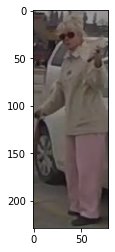

In [0]:

im=Image.open('00351.png')
im=im.crop([550.0, 691.0, 629.0, 920.0])
plt.imshow(im) 
im.size

In [0]:
 jaad['video_0001']['ped_annotations']['0_1_3b'].keys()

dict_keys(['old_id', 'frames', 'bbox', 'occlusion', 'behavior', 'attributes', 'appearance'])

In [0]:
jaad.keys()

dict_keys(['video_0001', 'video_0002', 'video_0003', 'video_0004', 'video_0005', 'video_0006', 'video_0007', 'video_0008', 'video_0010', 'video_0011', 'video_0012', 'video_0013', 'video_0014', 'video_0015', 'video_0016', 'video_0017', 'video_0018', 'video_0019', 'video_0020', 'video_0021', 'video_0022', 'video_0023', 'video_0024', 'video_0025', 'video_0026', 'video_0027', 'video_0028', 'video_0029', 'video_0030', 'video_0031', 'video_0032', 'video_0033', 'video_0034', 'video_0035', 'video_0036', 'video_0037', 'video_0038', 'video_0039', 'video_0040', 'video_0041', 'video_0042', 'video_0043', 'video_0044', 'video_0045', 'video_0046', 'video_0047', 'video_0048', 'video_0049', 'video_0050', 'video_0051', 'video_0052', 'video_0053', 'video_0054', 'video_0055', 'video_0056', 'video_0057', 'video_0058', 'video_0059', 'video_0060', 'video_0061', 'video_0062', 'video_0063', 'video_0064', 'video_0065', 'video_0066', 'video_0067', 'video_0068', 'video_0069', 'video_0070', 'video_0071', 'video_00

In [0]:
jaad['video_0001']['ped_annotations']['0_1_3b']['behavior'].keys()

dict_keys(['cross', 'reaction', 'hand_gesture', 'look', 'action', 'nod'])